# Extra Credit: Temporal Airbnb Seasonality and Modeling (EAS 510)

Hey, this notebook dives into:
- Creating night-by-night panel datasets for each city and snapshot
- Checking out seasonality with the required plots
- Setting up a time-based train/valid/test split to avoid any data leaks
- Training XGBoost and Neural Net models for:
  - **Regression**: predicting nightly prices
  - **Classification**: figuring out if a place gets booked
- Tracking Neural Net training with TensorBoard


### Install required Libraries

In [28]:


# import sys, subprocess

# def pip_install(pkgs):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# pip_install(["pandas", "numpy", "matplotlib", "scikit-learn", "xgboost", "tensorflow", "pyarrow"])


### Imports and config

In [29]:
from pathlib import Path
import os

print("CWD:", os.getcwd())

DATA_ROOT = Path(".")
print("DATA_ROOT:", DATA_ROOT.resolve())
print("DATA_ROOT exists?", DATA_ROOT.exists())

if DATA_ROOT.exists():
    print("Top-level items inside BONUS_ASSIGNMENT:")
    print([p.name for p in DATA_ROOT.iterdir()])
else:
    print("❌ BONUS_ASSIGNMENT folder not found from this CWD.")
    print("Fix by either:")
    print("1) Moving notebook to the parent folder of BONUS_ASSIGNMENT, or")
    print("2) Setting DATA_ROOT = Path(r'FULL_PATH_TO/BONUS_ASSIGNMENT')")


CWD: c:\Users\Admin\Desktop\BAI Projects\bonus_assignment
DATA_ROOT: C:\Users\Admin\Desktop\BAI Projects\bonus_assignment
DATA_ROOT exists? True
Top-level items inside BONUS_ASSIGNMENT:
['Austin', 'bonus.ipynb', 'cache_panels', 'Chicago', 'extra_credit_assignment.pdf', 'extra_credit_rubric.pdf', 'logs', 'Santa_Cruz', 'venv', 'WashingtonDC']


In [30]:
DATASETS = {
    ("Austin", "3625"): {
        "calendar": DATA_ROOT/"Austin"/"austin_calendar_3625.csv.gz",
        "listings": DATA_ROOT/"Austin"/"austin_listings_3625.csv.gz",
    },
    ("Austin", "121424"): {
        "calendar": DATA_ROOT/"Austin"/"austin_calendar_121424.csv.gz",
        "listings": DATA_ROOT/"Austin"/"austin_listings_121424.csv.gz",
    },

    ("Chicago", "31125"): {
        "calendar": DATA_ROOT/"Chicago"/"chicago_calendar_31125.csv.gz",
        "listings": DATA_ROOT/"Chicago"/"chicago_listings_31125.csv.gz",
    },
    ("Chicago", "121824"): {
        "calendar": DATA_ROOT/"Chicago"/"chicago_calendar_121824.csv.gz",
        "listings": DATA_ROOT/"Chicago"/"chicago_listings_121824.csv.gz",
    },

    ("Santa_Cruz", "32825"): {
        "calendar": DATA_ROOT/"Santa_Cruz"/"santacruz_calendar_32825.csv.gz",
        "listings": DATA_ROOT/"Santa_Cruz"/"santacruz_listings_32825.csv.gz",
    },
    ("Santa_Cruz", "123125"): {
        "calendar": DATA_ROOT/"Santa_Cruz"/"santacruz_calendar_123125.csv.gz",
        "listings": DATA_ROOT/"Santa_Cruz"/"santacruz_listings_123125.csv.gz",
    },

    ("WashingtonDC", "31325"): {
        "calendar": DATA_ROOT/"WashingtonDC"/"wdc_calendar_31325.csv.gz",
        "listings": DATA_ROOT/"WashingtonDC"/"wdc_listings_31325.csv.gz",
    },
    ("WashingtonDC", "121825"): {
        "calendar": DATA_ROOT/"WashingtonDC"/"wdc_calendar_121825.csv.gz",
        "listings": DATA_ROOT/"WashingtonDC"/"wdc_listings_121825.csv.gz",
    },
}

missing = []
for k, v in DATASETS.items():
    if not v["calendar"].exists(): missing.append(("calendar", k, v["calendar"]))
    if not v["listings"].exists(): missing.append(("listings", k, v["listings"]))

if missing:
    print("❌ Missing files:")
    for typ, k, p in missing:
        print(" -", typ, k, p)
    raise FileNotFoundError("Fix paths above to match your local folder.")
else:
    print("✅ All dataset paths found.")


✅ All dataset paths found.


#### Cleaning plus Category Capping helper functions

In [31]:
def clean_price_to_float(series: pd.Series) -> pd.Series:
    s = series.astype(str).replace("nan", np.nan)
    s = s.str.replace(r"[$,]", "", regex=True)
    s = pd.to_numeric(s, errors="coerce")
    return s

def tf_to_int(series: pd.Series) -> pd.Series:
    # Handles 't'/'f', True/False, 1/0
    if series.dtype == bool:
        return series.astype(int)
    s = series.astype(str).str.lower()
    return s.map({"t": 1, "f": 0, "true": 1, "false": 0, "1": 1, "0": 0}).fillna(0).astype(int)

def cap_top_k_categories(df: pd.DataFrame, col: str, k: int = 25) -> pd.DataFrame:
    if col not in df.columns:
        return df
    top = df[col].value_counts(dropna=True).head(k).index
    df[col] = df[col].where(df[col].isin(top), other="Other")
    df[col] = df[col].fillna("Missing")
    return df


In [32]:
def temporal_split_by_month(df: pd.DataFrame, train_months=9, valid_months=2):
    df = df.dropna(subset=["date"]).copy()
    df["year_month"] = df["date"].dt.to_period("M")

    months_sorted = np.array(sorted(df["year_month"].unique()))
    if len(months_sorted) < (train_months + valid_months + 1):
        raise ValueError(f"Not enough months in snapshot range: only {len(months_sorted)}")

    train_set = set(months_sorted[:train_months])
    valid_set = set(months_sorted[train_months:train_months+valid_months])
    test_set  = set(months_sorted[train_months+valid_months:])

    train_df = df[df["year_month"].isin(train_set)]
    valid_df = df[df["year_month"].isin(valid_set)]
    test_df  = df[df["year_month"].isin(test_set)]

    return train_df, valid_df, test_df


### Load and build panel

In [33]:
def load_snapshot(listings_path: Path, calendar_path: Path):
    # Calendar: read required columns (if present)
    cal = pd.read_csv(calendar_path, compression="gzip", low_memory=False)
    if "price" not in cal.columns and "adjusted_price" in cal.columns:
        cal = cal.rename(columns={"adjusted_price": "price"})

    needed_cal = ["listing_id", "date", "available", "price", "minimum_nights", "maximum_nights"]
    keep_cal = [c for c in needed_cal if c in cal.columns]
    cal = cal[keep_cal].copy()

    # Listings: load then select a safe subset (varies by city)
    listings_all = pd.read_csv(listings_path, compression="gzip", low_memory=False)

    # Normalize key to listing_id
    if "listing_id" not in listings_all.columns and "id" in listings_all.columns:
        listings_all = listings_all.rename(columns={"id": "listing_id"})

    desired_listing_cols = [
        "listing_id",
        "accommodates", "bedrooms", "beds",
        "room_type", "property_type", "neighbourhood_cleansed",
        "number_of_reviews", "review_scores_rating",
        "host_is_superhost", "instant_bookable"
    ]
    keep_list = [c for c in desired_listing_cols if c in listings_all.columns]
    listings = listings_all[keep_list].copy()

    return listings, cal

def build_panel(listings: pd.DataFrame, cal: pd.DataFrame, city: str, snapshot: str,
                save_sample_parquet: bool = True, sample_rows: int = 100_000) -> pd.DataFrame:
    # Evidence (shapes/head/dtypes)
    print(f"\n===== {city} | snapshot {snapshot} =====")
    print("LISTINGS shape:", listings.shape)
    display(listings.head())
    print(listings.dtypes)

    print("\nCALENDAR shape:", cal.shape)
    display(cal.head())
    print(cal.dtypes)

    # Left merge on listing_id (1 row per listing/date)
    df = cal.merge(listings, on="listing_id", how="left")

    # Clean + transform
    df["price"] = clean_price_to_float(df["price"]) if "price" in df.columns else np.nan
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    if "available" in df.columns:
        df["is_booked"] = (df["available"].astype(str).str.lower() == "f").astype(int)
    else:
        df["is_booked"] = np.nan

    # Time features
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype("Int64")
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    df["day_of_year"] = df["date"].dt.dayofyear

    # Quick verification
    print("\nMERGED panel shape:", df.shape)
    show_cols = [c for c in ["listing_id","date","price","available","is_booked","month","day_of_week","week_of_year","is_weekend","day_of_year"] if c in df.columns]
    display(df[show_cols].head())

    # Optional: save sample parquet
    # Optional: save sample as CSV.GZ (no pyarrow required)
    if save_sample_parquet:
        out = CACHE_DIR / f"panel_{city}_{snapshot}_sample{sample_rows}.csv.gz"
        df.head(sample_rows).to_csv(out, index=False, compression="gzip")
        print("Saved sample CSV:", out)


    return df


### Building Panels

In [34]:
PANELS = {}

for (city, snap), paths in DATASETS.items():
    listings, cal = load_snapshot(paths["listings"], paths["calendar"])
    panel = build_panel(listings, cal, city, snap, save_sample_parquet=True, sample_rows=100_000)
    PANELS[(city, snap)] = panel

print("\n✅ Built panels:", len(PANELS))



===== Austin | snapshot 3625 =====
LISTINGS shape: (15431, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,5456,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f
1,5769,2,NaN,NaN,Private room,Private room in home,78729,299,4.90,f,f
2,6413,2,0.0,1.0,Entire home/apt,Entire guesthouse,78704,122,4.98,t,f
3,6448,2,1.0,2.0,Entire home/apt,Entire guesthouse,78704,334,4.97,t,t
4,8502,2,1.0,NaN,Entire home/apt,Entire guest suite,78741,53,4.56,f,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed      int64
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (5635043, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,5456,2025-03-13,t,$95.00,2.0,90.0
1,5456,2025-03-14,f,$95.00,2.0,90.0
2,5456,2025-03-15,f,$95.00,2.0,90.0
3,5456,2025-03-16,f,$95.00,2.0,90.0
4,5456,2025-03-17,f,$95.00,2.0,90.0


listing_id          int64
date               object
available          object
price              object
minimum_nights    float64
maximum_nights    float64
dtype: object

MERGED panel shape: (5635043, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,5456,2025-03-13,95.0,t,0,3,3,11,0,72
1,5456,2025-03-14,95.0,f,1,3,4,11,0,73
2,5456,2025-03-15,95.0,f,1,3,5,11,1,74
3,5456,2025-03-16,95.0,f,1,3,6,11,1,75
4,5456,2025-03-17,95.0,f,1,3,0,12,0,76


Saved sample CSV: cache_panels\panel_Austin_3625_sample100000.csv.gz

===== Austin | snapshot 121424 =====
LISTINGS shape: (15500, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,69810,2,1.0,NaN,Entire home/apt,Entire guesthouse,78704,445,4.98,f,f
1,70812,3,1.0,1.0,Entire home/apt,Entire guesthouse,78704,188,4.89,t,f
2,72833,2,1.0,NaN,Entire home/apt,Entire guesthouse,78731,413,4.91,f,f
3,73005,6,2.0,4.0,Entire home/apt,Entire townhouse,78727,45,4.84,f,f
4,73289,4,2.0,2.0,Entire home/apt,Entire rental unit,78705,62,4.88,t,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed      int64
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (5654056, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,5456,2024-12-15,f,$95.00,2.0,90.0
1,5456,2024-12-16,t,$95.00,2.0,90.0
2,5456,2024-12-17,t,$95.00,2.0,90.0
3,5456,2024-12-18,t,$95.00,2.0,90.0
4,5456,2024-12-19,t,$95.00,2.0,90.0


listing_id          int64
date               object
available          object
price              object
minimum_nights    float64
maximum_nights    float64
dtype: object

MERGED panel shape: (5654056, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,5456,2024-12-15,95.0,f,1,12,6,50,1,350
1,5456,2024-12-16,95.0,t,0,12,0,51,0,351
2,5456,2024-12-17,95.0,t,0,12,1,51,0,352
3,5456,2024-12-18,95.0,t,0,12,2,51,0,353
4,5456,2024-12-19,95.0,t,0,12,3,51,0,354


Saved sample CSV: cache_panels\panel_Austin_121424_sample100000.csv.gz

===== Chicago | snapshot 31125 =====
LISTINGS shape: (8748, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,2384,1,1.0,1.0,Private room,Private room in condo,Hyde Park,250,4.99,f,f
1,7126,2,1.0,1.0,Entire home/apt,Entire rental unit,West Town,569,4.72,t,f
2,10945,4,2.0,2.0,Entire home/apt,Entire rental unit,Lincoln Park,117,4.72,t,t
3,28749,6,3.0,3.0,Entire home/apt,Entire loft,Logan Square,244,4.82,t,f
4,71930,2,1.0,1.0,Private room,Private room in rental unit,West Town,129,4.89,t,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (3187677, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,2384,2025-03-15,t,$125.00,3.0,89.0
1,2384,2025-03-16,t,$125.00,3.0,89.0
2,2384,2025-03-17,t,$125.00,3.0,89.0
3,2384,2025-03-18,t,$125.00,3.0,89.0
4,2384,2025-03-19,t,$125.00,3.0,89.0


listing_id          int64
date               object
available          object
price              object
minimum_nights    float64
maximum_nights    float64
dtype: object

MERGED panel shape: (3187677, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,2384,2025-03-15,125.0,t,0,3,5,11,1,74
1,2384,2025-03-16,125.0,t,0,3,6,11,1,75
2,2384,2025-03-17,125.0,t,0,3,0,12,0,76
3,2384,2025-03-18,125.0,t,0,3,1,12,0,77
4,2384,2025-03-19,125.0,t,0,3,2,12,0,78


Saved sample CSV: cache_panels\panel_Chicago_31125_sample100000.csv.gz

===== Chicago | snapshot 121824 =====
LISTINGS shape: (8691, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,2396340,6,3.0,4.0,Entire home/apt,Entire rental unit,West Town,534,4.90,t,f
1,2437230,4,2.0,2.0,Entire home/apt,Entire condo,North Center,107,4.92,t,f
2,2479175,2,1.0,1.0,Entire home/apt,Entire rental unit,Lincoln Square,289,4.79,t,f
3,2499596,3,1.0,2.0,Entire home/apt,Entire condo,West Town,190,4.80,f,f
4,2515629,1,1.0,1.0,Private room,Private room in townhouse,East Garfield Park,185,4.77,f,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (3169332, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,2396340,2024-12-18,f,$302.00,2,1125
1,2396340,2024-12-19,t,$302.00,2,1125
2,2396340,2024-12-20,t,$302.00,2,1125
3,2396340,2024-12-21,t,$302.00,2,1125
4,2396340,2024-12-22,f,$302.00,2,1125


listing_id         int64
date              object
available         object
price             object
minimum_nights     int64
maximum_nights     int64
dtype: object

MERGED panel shape: (3169332, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,2396340,2024-12-18,302.0,f,1,12,2,51,0,353
1,2396340,2024-12-19,302.0,t,0,12,3,51,0,354
2,2396340,2024-12-20,302.0,t,0,12,4,51,0,355
3,2396340,2024-12-21,302.0,t,0,12,5,51,1,356
4,2396340,2024-12-22,302.0,f,1,12,6,51,1,357


Saved sample CSV: cache_panels\panel_Chicago_121824_sample100000.csv.gz

===== Santa_Cruz | snapshot 32825 =====
LISTINGS shape: (1684, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,8357,3,1.0,2.0,Private room,Private room in farm stay,Unincorporated Areas,1945,4.88,t,f
1,11879,2,1.0,1.0,Private room,Private room in home,Unincorporated Areas,103,4.83,t,f
2,24548,2,1.0,1.0,Entire home/apt,Entire guest suite,City of Santa Cruz,587,4.93,t,f
3,31721,2,1.0,1.0,Entire home/apt,Entire cottage,City of Capitola,415,4.74,t,f
4,37791,2,1.0,1.0,Entire home/apt,Entire rental unit,City of Santa Cruz,92,4.60,f,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (613431, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,8357,2025-03-28,f,$145.00,2,90
1,8357,2025-03-29,f,$145.00,2,90
2,8357,2025-03-30,t,$145.00,2,90
3,8357,2025-03-31,f,$145.00,2,90
4,8357,2025-04-01,f,$145.00,2,90


listing_id         int64
date              object
available         object
price             object
minimum_nights     int64
maximum_nights     int64
dtype: object

MERGED panel shape: (613431, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,8357,2025-03-28,145.0,f,1,3,4,13,0,87
1,8357,2025-03-29,145.0,f,1,3,5,13,1,88
2,8357,2025-03-30,145.0,t,0,3,6,13,1,89
3,8357,2025-03-31,145.0,f,1,3,0,14,0,90
4,8357,2025-04-01,145.0,f,1,4,1,14,0,91


Saved sample CSV: cache_panels\panel_Santa_Cruz_32825_sample100000.csv.gz

===== Santa_Cruz | snapshot 123125 =====
LISTINGS shape: (1703, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,8357,3,1.0,2.0,Private room,Private room in farm stay,Unincorporated Areas,1935,4.88,t,f
1,11879,2,1.0,1.0,Private room,Private room in home,Unincorporated Areas,103,4.83,t,f
2,24548,2,1.0,NaN,Entire home/apt,Entire guest suite,City of Santa Cruz,586,4.93,t,f
3,31721,2,1.0,1.0,Entire home/apt,Entire cottage,City of Capitola,415,4.74,t,f
4,37791,2,1.0,1.0,Entire home/apt,Entire rental unit,City of Santa Cruz,92,4.60,t,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (620390, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,8357,2024-12-31,f,$145.00,2,90
1,8357,2025-01-01,f,$145.00,2,90
2,8357,2025-01-02,f,$145.00,2,90
3,8357,2025-01-03,f,$145.00,2,90
4,8357,2025-01-04,f,$145.00,2,90


listing_id         int64
date              object
available         object
price             object
minimum_nights     int64
maximum_nights     int64
dtype: object

MERGED panel shape: (620390, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,8357,2024-12-31,145.0,f,1,12,1,1,0,366
1,8357,2025-01-01,145.0,f,1,1,2,1,0,1
2,8357,2025-01-02,145.0,f,1,1,3,1,0,2
3,8357,2025-01-03,145.0,f,1,1,4,1,0,3
4,8357,2025-01-04,145.0,f,1,1,5,1,1,4


Saved sample CSV: cache_panels\panel_Santa_Cruz_123125_sample100000.csv.gz

===== WashingtonDC | snapshot 31325 =====
LISTINGS shape: (6257, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,3686,1,1.0,2.0,Private room,Private room in home,Historic Anacostia,84,4.64,f,f
1,3943,2,1.0,1.0,Private room,Private room in townhouse,"Edgewood, Bloomingdale, Truxton Circle, Eckington",534,4.86,t,f
2,4197,1,1.0,1.0,Private room,Private room in home,"Capitol Hill, Lincoln Park",64,4.87,t,f
3,4529,2,1.0,2.0,Private room,Private room in home,"Eastland Gardens, Kenilworth",102,4.66,NaN,f
4,5589,3,1.0,NaN,Entire home/apt,Entire rental unit,"Kalorama Heights, Adams Morgan, Lanier Heights",96,4.50,f,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (2282941, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,3686,2025-03-13,t,$67.00,NaN,NaN
1,3686,2025-03-14,t,$67.00,31.0,365.0
2,3686,2025-03-15,t,$67.00,31.0,365.0
3,3686,2025-03-16,t,$67.00,31.0,365.0
4,3686,2025-03-17,t,$67.00,31.0,365.0


listing_id          int64
date               object
available          object
price              object
minimum_nights    float64
maximum_nights    float64
dtype: object

MERGED panel shape: (2282941, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,3686,2025-03-13,67.0,t,0,3,3,11,0,72
1,3686,2025-03-14,67.0,t,0,3,4,11,0,73
2,3686,2025-03-15,67.0,t,0,3,5,11,1,74
3,3686,2025-03-16,67.0,t,0,3,6,11,1,75
4,3686,2025-03-17,67.0,t,0,3,0,12,0,76


Saved sample CSV: cache_panels\panel_WashingtonDC_31325_sample100000.csv.gz

===== WashingtonDC | snapshot 121825 =====
LISTINGS shape: (5964, 11)


,listing_id,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable
0,3686,1,1.0,2.0,Private room,Private room in home,Historic Anacostia,84,4.64,f,f
1,3943,2,1.0,1.0,Private room,Private room in townhouse,"Edgewood, Bloomingdale, Truxton Circle, Eckington",529,4.86,t,f
2,4197,1,1.0,1.0,Private room,Private room in home,"Capitol Hill, Lincoln Park",63,4.87,t,f
3,4529,2,1.0,2.0,Private room,Private room in home,"Eastland Gardens, Kenilworth",102,4.66,NaN,f
4,5589,3,1.0,1.0,Entire home/apt,Entire rental unit,"Kalorama Heights, Adams Morgan, Lanier Heights",96,4.50,f,f


listing_id                  int64
accommodates                int64
bedrooms                  float64
beds                      float64
room_type                  object
property_type              object
neighbourhood_cleansed     object
number_of_reviews           int64
review_scores_rating      float64
host_is_superhost          object
instant_bookable           object
dtype: object

CALENDAR shape: (2176398, 6)


,listing_id,date,available,price,minimum_nights,maximum_nights
0,3686,2024-12-18,t,$67.00,31,365
1,3686,2024-12-19,t,$67.00,31,365
2,3686,2024-12-20,t,$67.00,31,365
3,3686,2024-12-21,t,$67.00,31,365
4,3686,2024-12-22,t,$67.00,31,365


listing_id         int64
date              object
available         object
price             object
minimum_nights     int64
maximum_nights     int64
dtype: object

MERGED panel shape: (2176398, 22)


,listing_id,date,price,available,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,3686,2024-12-18,67.0,t,0,12,2,51,0,353
1,3686,2024-12-19,67.0,t,0,12,3,51,0,354
2,3686,2024-12-20,67.0,t,0,12,4,51,0,355
3,3686,2024-12-21,67.0,t,0,12,5,51,1,356
4,3686,2024-12-22,67.0,t,0,12,6,51,1,357


Saved sample CSV: cache_panels\panel_WashingtonDC_121825_sample100000.csv.gz

✅ Built panels: 8


## Part 2: Checking Out Seasonality (The Required Plots)


In [35]:
def seasonality_plots(df: pd.DataFrame, title_prefix: str, listing_type_col: str = "room_type"):
    df2 = df.dropna(subset=["date", "price"]).copy()

    # 1) Avg price by month
    by_month_price = df2.groupby("month")["price"].mean().sort_index()

    plt.figure()
    plt.plot(by_month_price.index, by_month_price.values, marker="o")
    plt.title(f"{title_prefix} - Avg Price by Month")
    plt.xlabel("Month")
    plt.ylabel("Average Price")
    plt.grid(True)
    plt.show()

    # 2) Avg booking probability by month
    by_month_book = df2.groupby("month")["is_booked"].mean().sort_index()

    plt.figure()
    plt.plot(by_month_book.index, by_month_book.values, marker="o")
    plt.title(f"{title_prefix} - Booking Probability by Month")
    plt.xlabel("Month")
    plt.ylabel("P(Booked) = mean(is_booked)")
    plt.grid(True)
    plt.show()

    # 3) Weekend vs weekday bars (price + booking)
    wk = df2.groupby("is_weekend")[["price", "is_booked"]].mean().rename(index={0: "Weekday", 1: "Weekend"})

    plt.figure()
    plt.bar(wk.index.astype(str), wk["price"].values)
    plt.title(f"{title_prefix} - Weekend vs Weekday Avg Price")
    plt.xlabel("")
    plt.ylabel("Average Price")
    plt.show()

    plt.figure()
    plt.bar(wk.index.astype(str), wk["is_booked"].values)
    plt.title(f"{title_prefix} - Weekend vs Weekday Booking Probability")
    plt.xlabel("")
    plt.ylabel("P(Booked)")
    plt.show()

    # 4) Avg price by month grouped by listing type (room_type/property_type/...)
    if listing_type_col in df2.columns:
        sub = df2.copy()
        sub = cap_top_k_categories(sub, listing_type_col, k=6)
        g = sub.groupby(["month", listing_type_col])["price"].mean().reset_index()

        plt.figure()
        for cat in g[listing_type_col].unique():
            s = g[g[listing_type_col] == cat].sort_values("month")
            plt.plot(s["month"], s["price"], marker="o", label=str(cat))
        plt.title(f"{title_prefix} - Avg Price by Month by {listing_type_col}")
        plt.xlabel("Month")
        plt.ylabel("Average Price")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"(Skipped grouped plot: '{listing_type_col}' not found)")


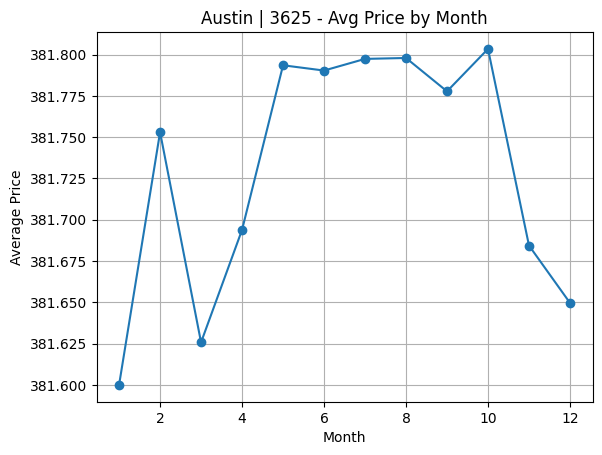

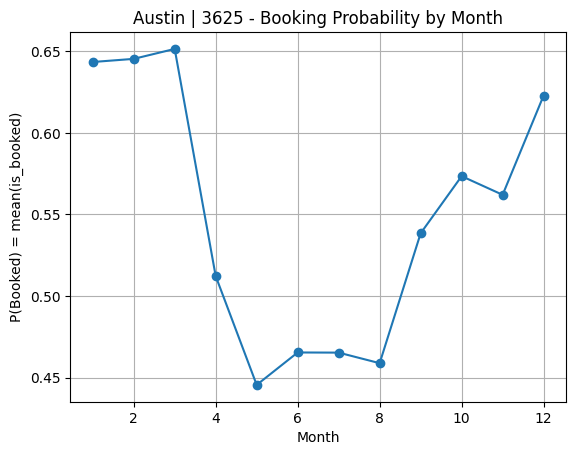

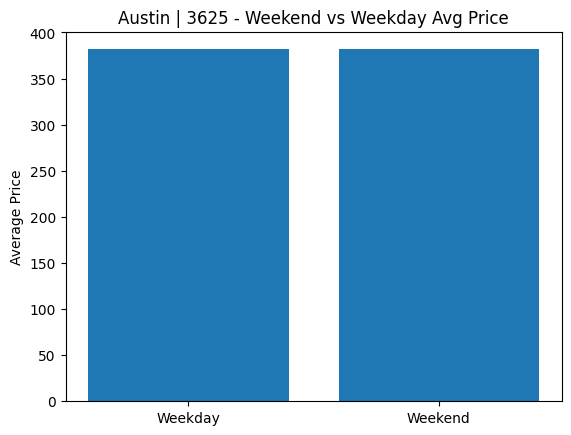

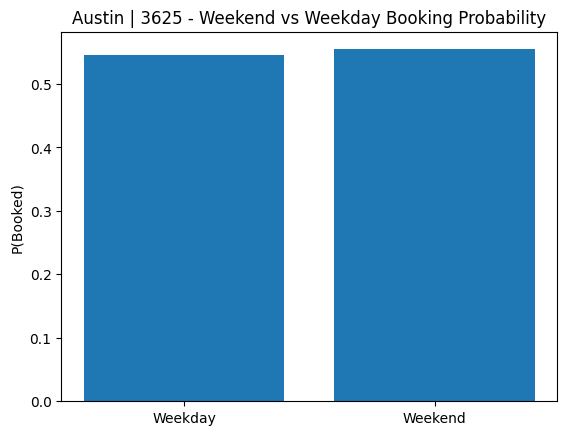

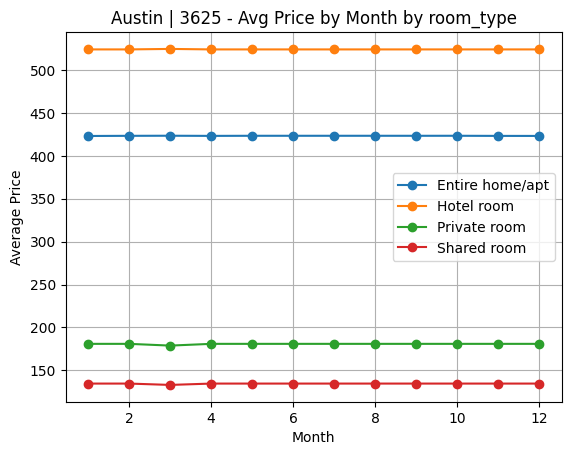

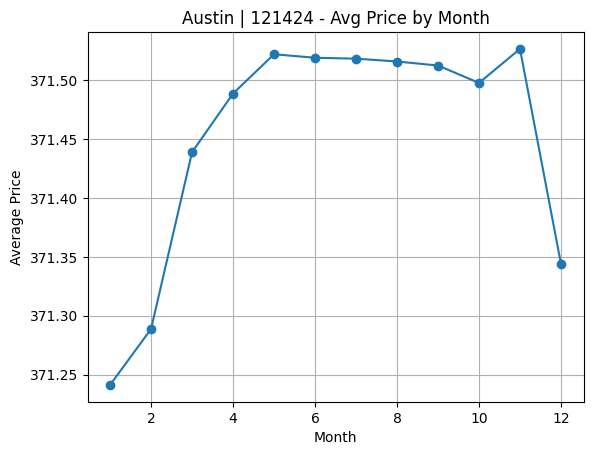

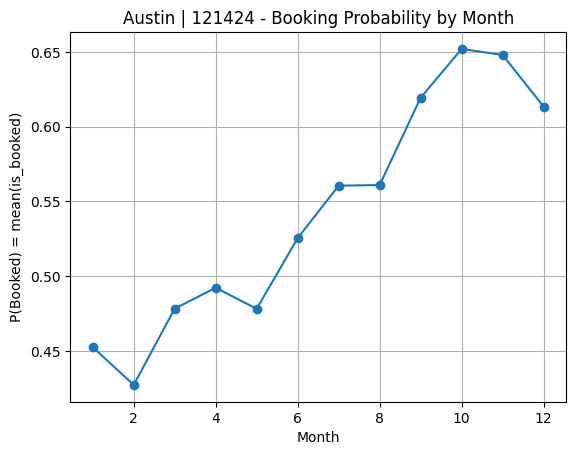

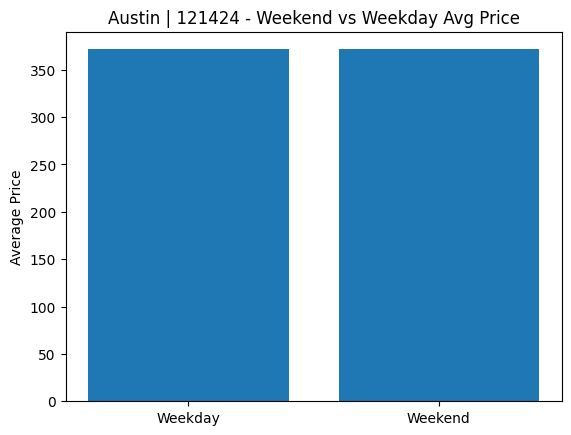

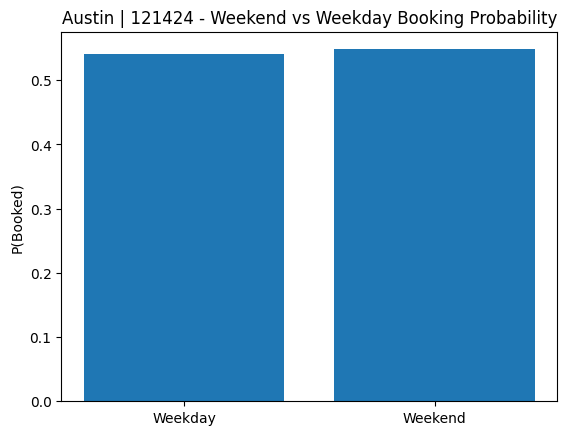

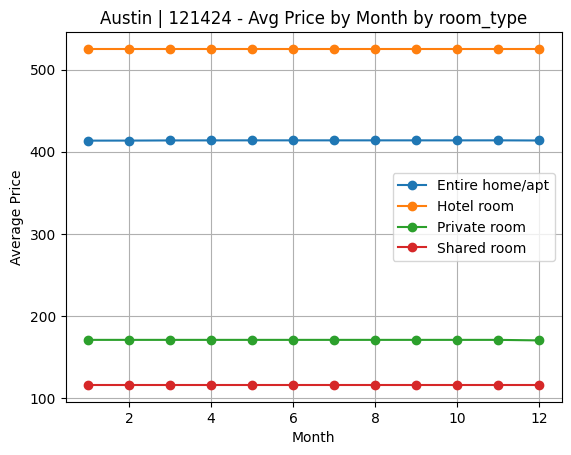

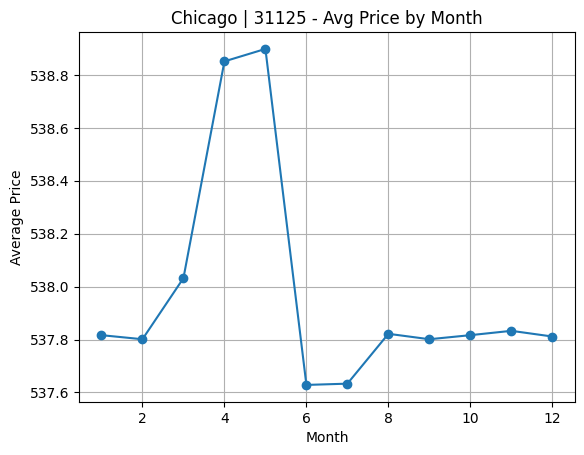

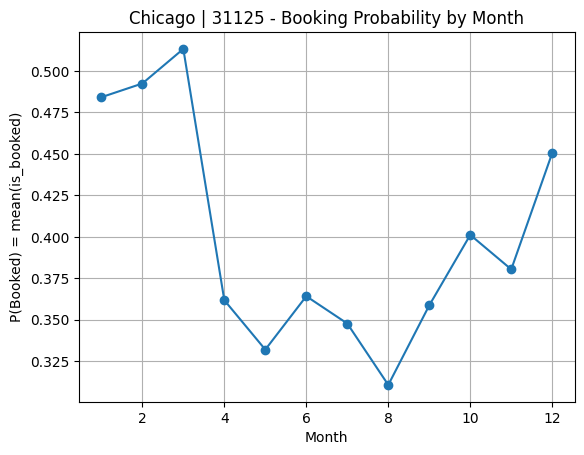

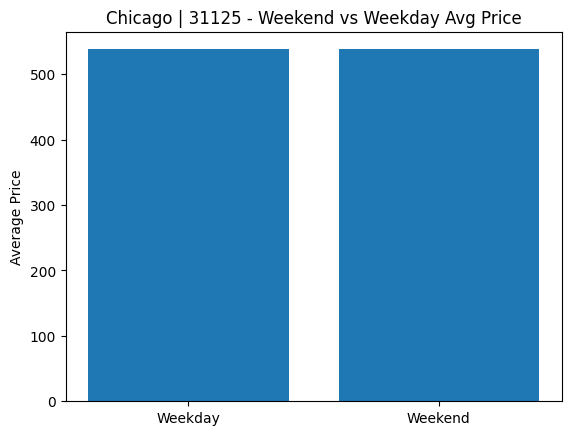

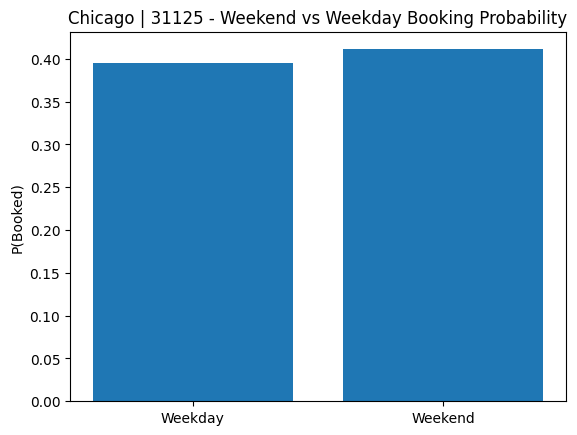

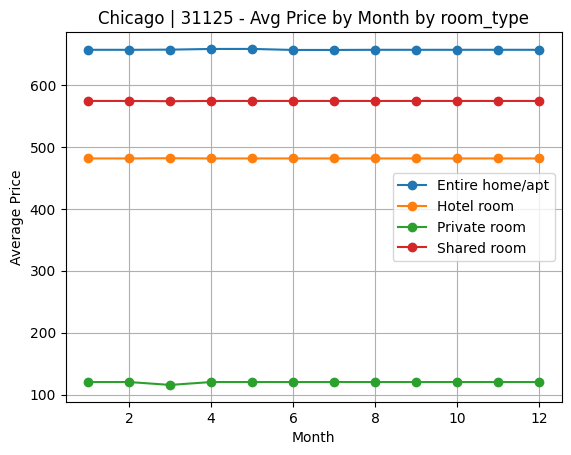

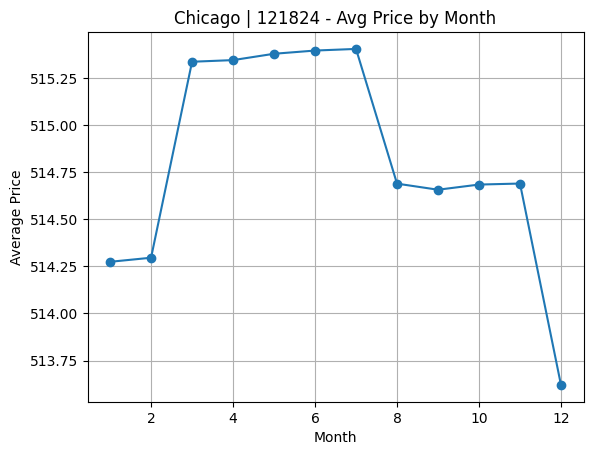

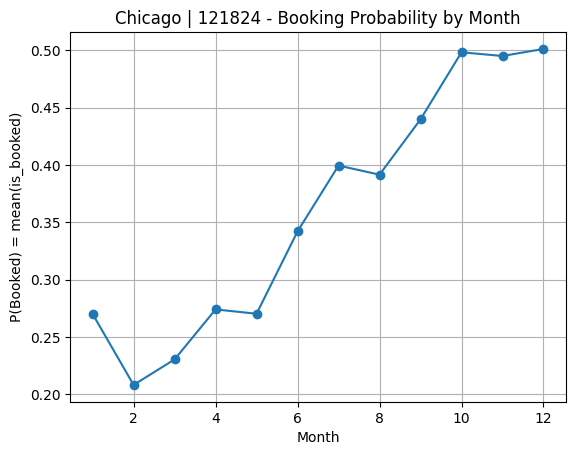

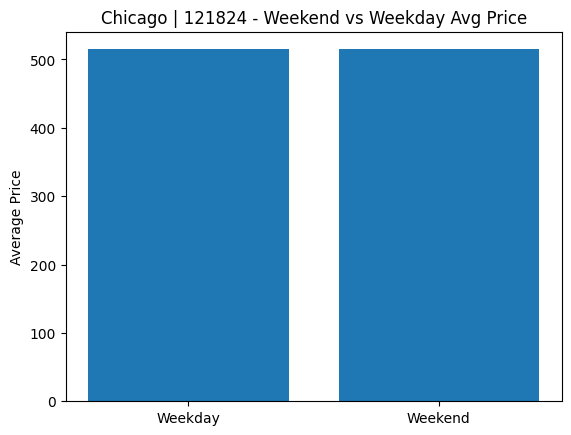

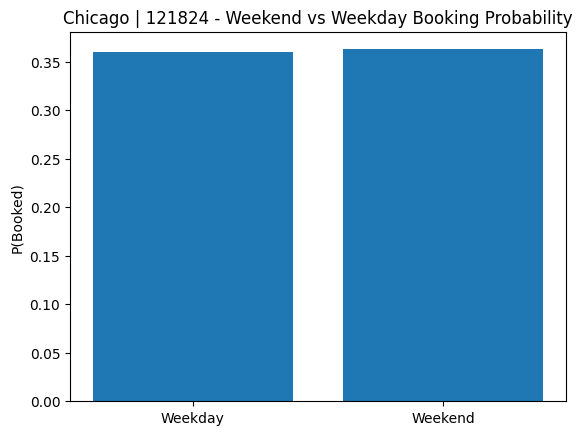

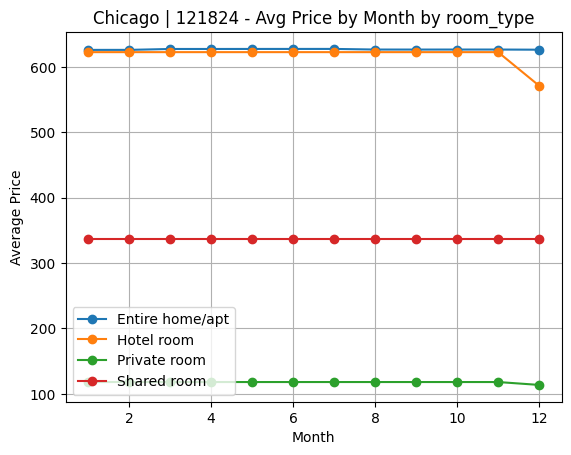

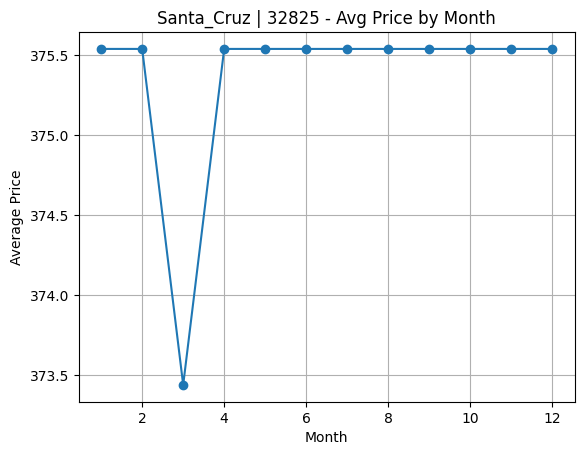

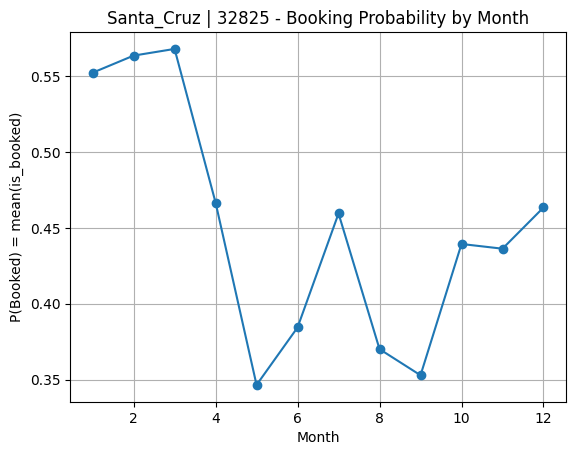

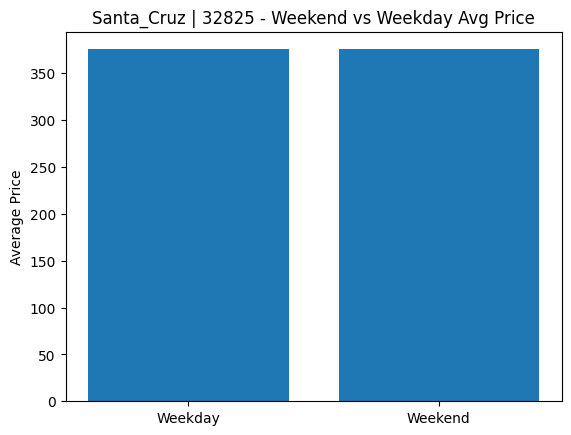

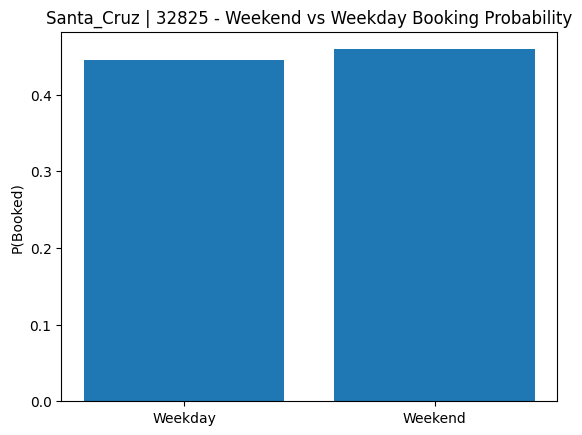

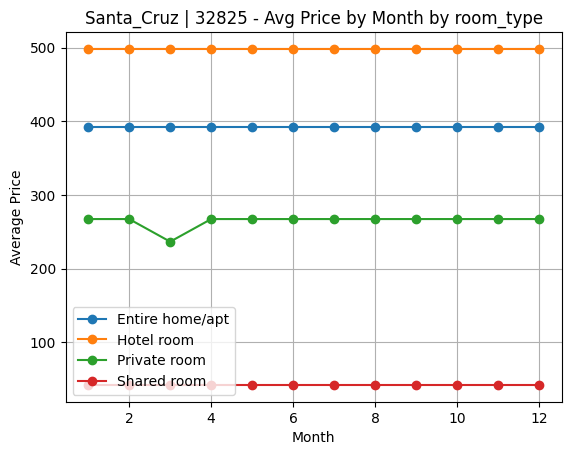

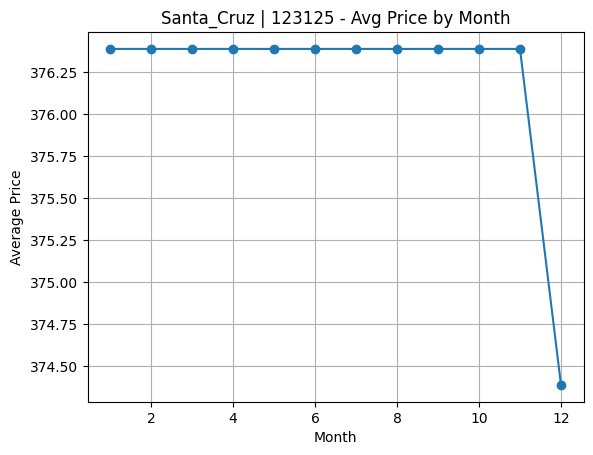

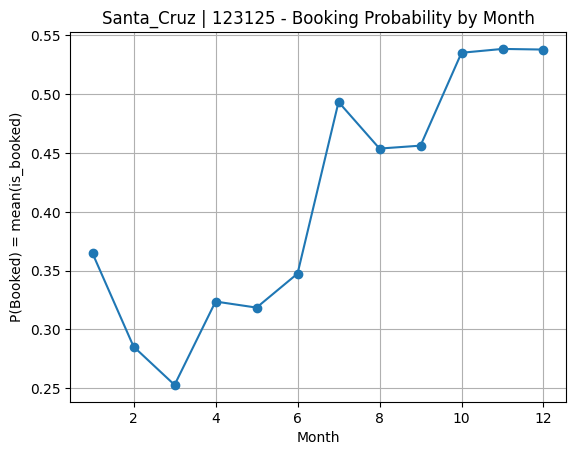

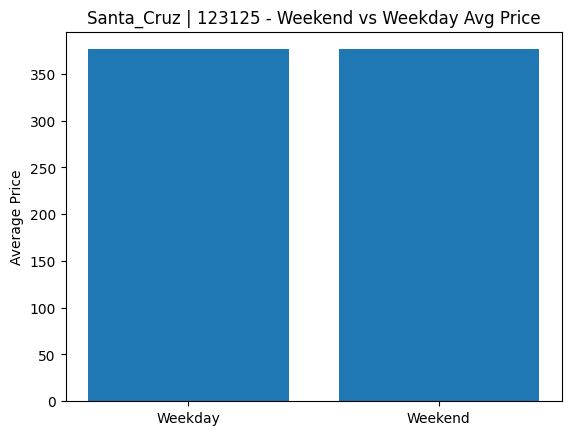

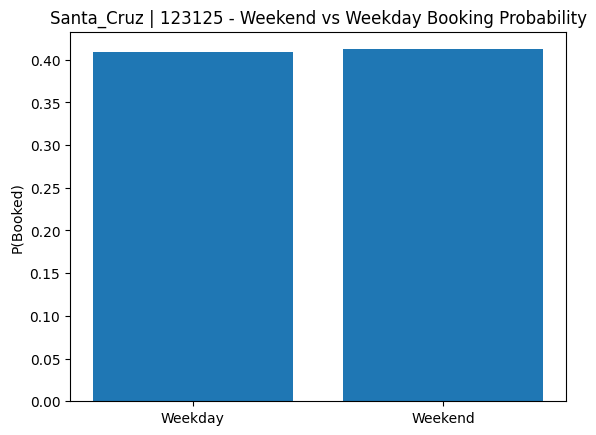

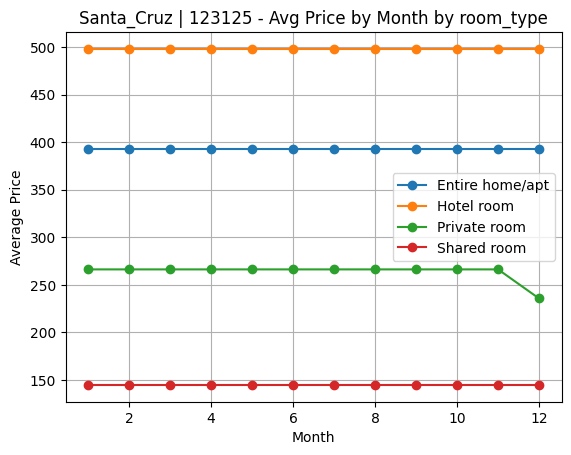

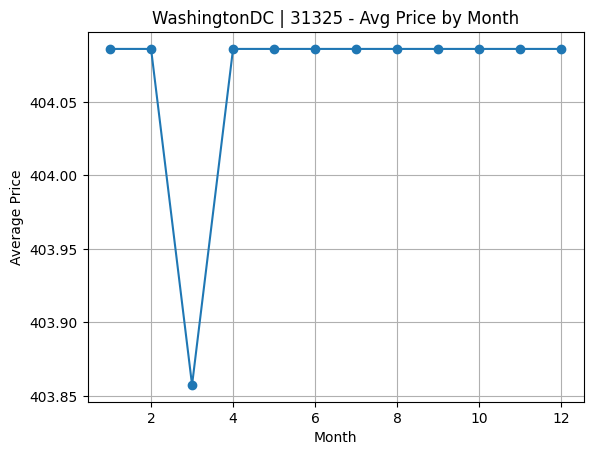

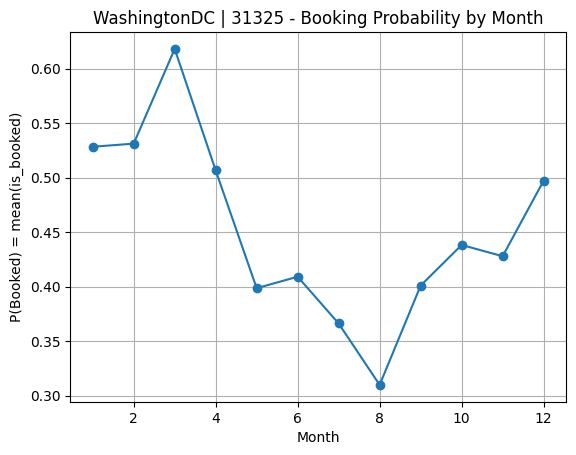

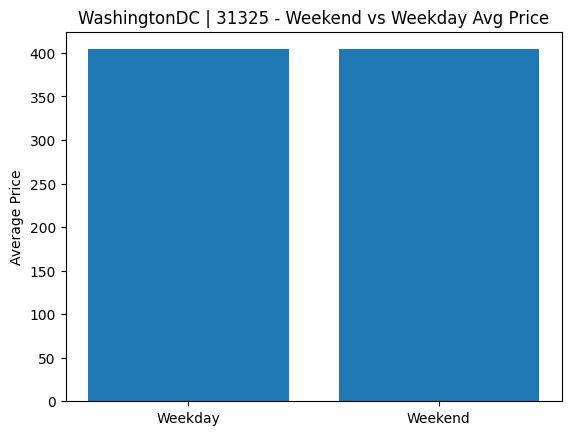

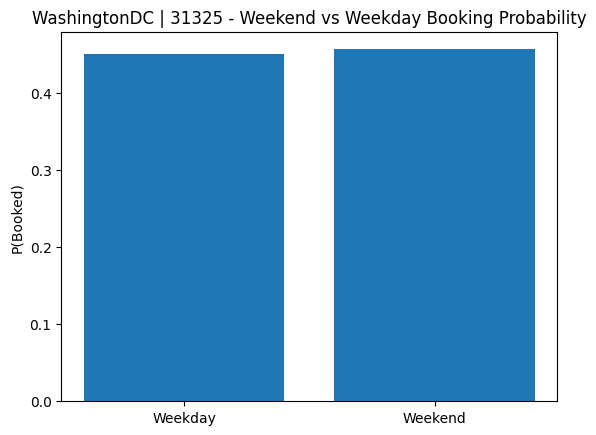

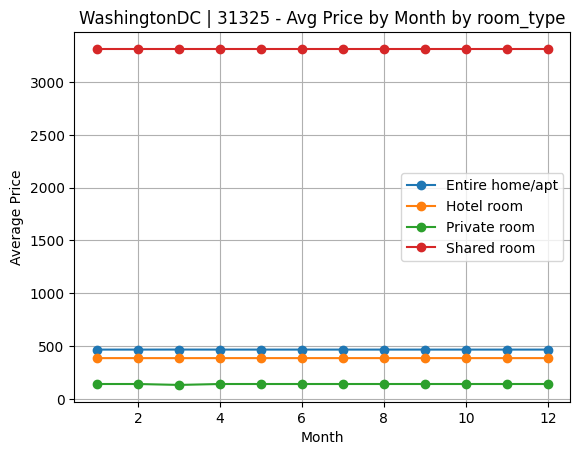

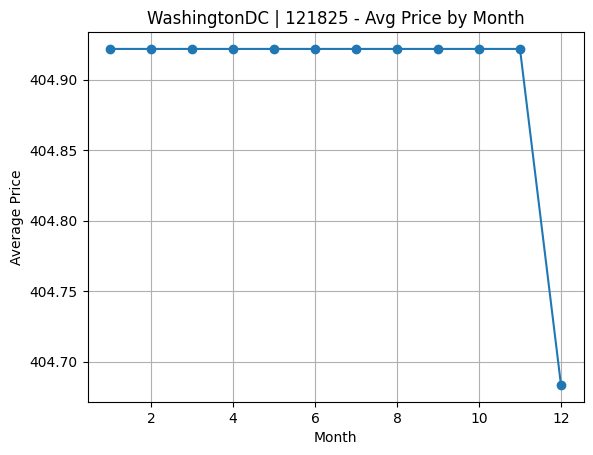

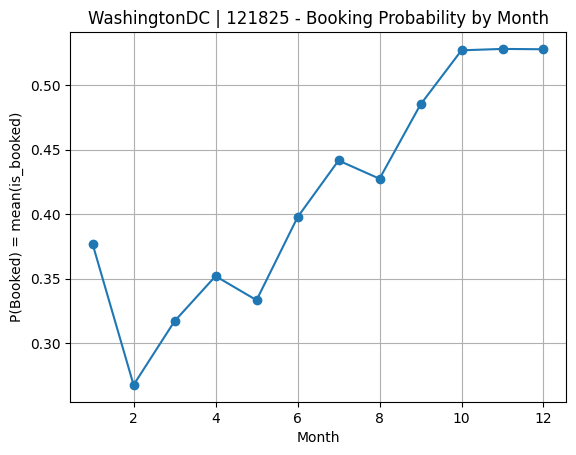

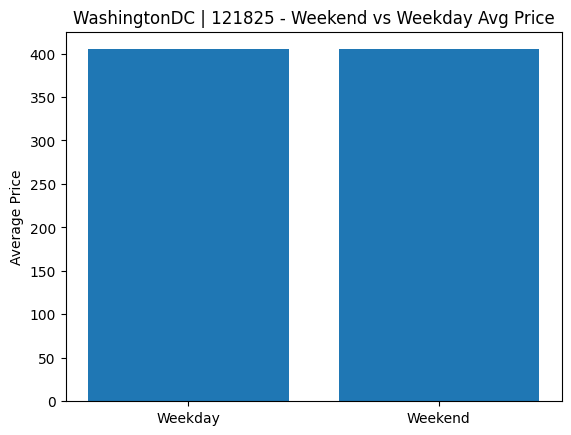

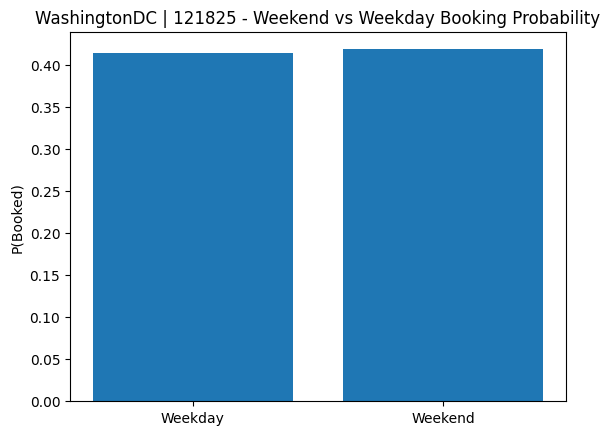

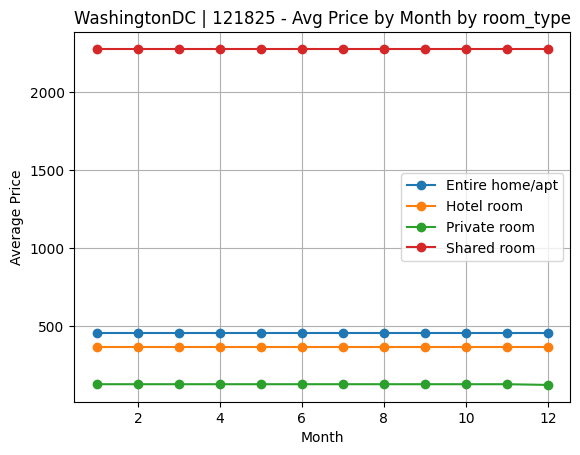

In [36]:
for (city, snap), df in PANELS.items():
    seasonality_plots(df, f"{city} | {snap}", listing_type_col="room_type")


## Part 2 Interpretation

### Austin | 6 March 2025
The average price stays super steady throughout the year, with just tiny changes from month to month. There's a slight peak in early fall (around October), and it's a bit lower in the early and late months. But booking chances show way more ups and downs: they're highest from Jan to Mar, drop hard in Apr-May (bottoming out around May), then slowly climb back up from late summer through fall and winter. Weekends and weekdays have basically the same average price (no big weekend bump), and weekends get booked a tad more often. Room type matters way more for price differences than the time of year: hotel rooms are always the priciest, followed by entire homes/apts, private rooms, and shared rooms at the bottom. These room type patterns stay pretty flat month after month.

### Austin | 14 December 2024
Prices are pretty flat again across the months, with a gentle climb from winter into spring/summer and a small dip in December. Booking chances follow a clear upward trend: they're lower in Jan-Feb, build steadily through spring and summer, peak around Oct-Nov, then drop a little in December. Weekends vs weekdays show almost no price difference, meaning minimal weekend fees here too. The room type breakdown is consistent and steady (hotel rooms top, entire homes/apts next, private rooms, shared rooms last), so room type calls the shots on prices more than seasonal changes.

### Chicago | 11 March 2025
Prices spike noticeably in Apr-May compared to the rest of the year, but stay flatter from summer through December. Booking chances are highest in Jan-Mar, then plunge in Apr-May, hit rock bottom around August, and bounce back in fall/winter (with December above the mid-year low). Weekends show a tiny boost for both price and bookings (just a bit higher). Room types are clearly separated and mostly stable: entire homes/apts are the most expensive, hotels next, shared rooms surprisingly pricey compared to private ones, and private rooms cheapest. The lines are mostly flat, showing weak monthly changes within each type.

### Chicago | 18 December 2024
Prices climb from winter into spring/summer (Mar-Jul is the peak range), then start dropping around August, bottoming out in December. Booking chances have strong seasonality: lowest in winter (especially Feb), then rising through late spring/summer, peaking in Oct-Dec (around 0.5). Weekends are a bit pricier and book slightly more. By room type, entire homes/apts and hotels are the top earners and stay stable, private rooms are lowest, shared in the middle. One exception: hotels dip in December, maybe due to end-of-year deals or changes in listings.

### Santa_Cruz | 28 March 2025
Prices are almost totally flat all year, with just one clear dip around March before leveling out. Booking chances are super seasonal: highest in Jan-Mar, crash in April (lowest around May), then partly recover in early summer and again in Oct-Dec. Weekends and weekdays price the same (no weekend premium), but weekends book a bit more. Room type pricing is rock solid: hotels top, entire homes/apts next, private rooms cheaper, shared lowest. The only variation is a dip for private rooms in March.

### Santa_Cruz | 31 December 2025
Prices hold steady across months, with only a small December drop. Booking chances are lowest in late winter/early spring (Feb-Mar), then gradually rise through spring, spike sharply in mid-summer (around July), and stay high into fall/winter, peaking in Oct-Dec. Weekends and weekdays price nearly the same, with weekends booking slightly more. Room type curves are mostly flat (hotels highest, entire homes/apts, private, shared), except private rooms dip in December, echoing the overall December softness.

### WashingtonDC | 13 March 2025
Prices are basically flat all year, with a small March dip—super weak seasonality. Booking chances peak in March, steadily decline into summer (lowest in August), then rebound through fall to December. Weekends and weekdays price the same, with weekends booking a touch more. Room types dominate: shared rooms are insanely expensive (total outlier), entire homes/apts and hotels mid-high, private rooms lowest. Otherwise, pretty constant month to month.

### WashingtonDC | 18 December 2025
Prices stay stable with a slight December drop. Booking chances bottom out in winter (especially Feb), then climb through spring/summer, hitting highs in Oct-Dec. Weekends and weekdays are almost identical in price and bookings. Room types are distinct and mostly flat: shared rooms are outliers with crazy high prices, entire homes/apts and hotels next, private lowest. Differences between types are huge compared to monthly shifts.



### choosing one dataset for modelling

In [37]:
# Modeling is required for both targets; the rubric does NOT require running models for all 8 datasets.
# Pick one dataset key here.
MODEL_KEY = ("Austin", "3625")  # change if you want

df_model = PANELS[MODEL_KEY].copy()
print("Using MODEL_KEY:", MODEL_KEY, "| rows:", len(df_model))
display(df_model.head())


Using MODEL_KEY: ('Austin', '3625') | rows: 5635043


,listing_id,date,available,price,minimum_nights,maximum_nights,accommodates,bedrooms,beds,room_type,property_type,neighbourhood_cleansed,number_of_reviews,review_scores_rating,host_is_superhost,instant_bookable,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,5456,2025-03-13,t,95.0,2.0,90.0,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f,0,3,3,11,0,72
1,5456,2025-03-14,f,95.0,2.0,90.0,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f,1,3,4,11,0,73
2,5456,2025-03-15,f,95.0,2.0,90.0,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f,1,3,5,11,1,74
3,5456,2025-03-16,f,95.0,2.0,90.0,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f,1,3,6,11,1,75
4,5456,2025-03-17,f,95.0,2.0,90.0,3,1.0,2.0,Entire home/apt,Entire guesthouse,78702,702,4.85,t,f,1,3,0,12,0,76


### Temporal split

In [38]:
def temporal_split_by_month(df: pd.DataFrame, train_months=9, valid_months=2):
    df = df.dropna(subset=["date"]).copy()
    df["year_month"] = df["date"].dt.to_period("M")
    months_sorted = np.array(sorted(df["year_month"].unique()))

    if len(months_sorted) < (train_months + valid_months + 1):
        raise ValueError(f"Not enough months in snapshot range: only {len(months_sorted)}")

    train_set = set(months_sorted[:train_months])
    valid_set = set(months_sorted[train_months:train_months+valid_months])
    test_set  = set(months_sorted[train_months+valid_months:])

    train_df = df[df["year_month"].isin(train_set)].copy()
    valid_df = df[df["year_month"].isin(valid_set)].copy()
    test_df  = df[df["year_month"].isin(test_set)].copy()

    print("Train months:", sorted(train_set)[:3], "...", sorted(train_set)[-3:])
    print("Valid months:", sorted(valid_set))
    print("Test months:", sorted(test_set)[:3], "...", sorted(test_set)[-3:])
    print("Shapes:", train_df.shape, valid_df.shape, test_df.shape)

    return train_df, valid_df, test_df

train_df, valid_df, test_df = temporal_split_by_month(df_model, train_months=9, valid_months=2)


Train months: [Period('2025-03', 'M'), Period('2025-04', 'M'), Period('2025-05', 'M')] ... [Period('2025-09', 'M'), Period('2025-10', 'M'), Period('2025-11', 'M')]
Valid months: [Period('2025-12', 'M'), Period('2026-01', 'M')]
Test months: [Period('2026-02', 'M'), Period('2026-03', 'M')] ... [Period('2026-02', 'M'), Period('2026-03', 'M')]
Shapes: (4087547, 23) (956102, 23) (591394, 23)


### Feature Selection and Basic Cleaning

In [39]:
# Clean booleans / cap categories for modeling
for d in [train_df, valid_df, test_df]:
    if "host_is_superhost" in d.columns:
        d["host_is_superhost"] = tf_to_int(d["host_is_superhost"])
    if "instant_bookable" in d.columns:
        d["instant_bookable"] = tf_to_int(d["instant_bookable"])
    if "room_type" in d.columns:
        d = cap_top_k_categories(d, "room_type", k=6)
    if "property_type" in d.columns:
        d = cap_top_k_categories(d, "property_type", k=10)
    if "neighbourhood_cleansed" in d.columns:
        d = cap_top_k_categories(d, "neighbourhood_cleansed", k=25)

# Choose candidate features (only those that exist)
candidate_numeric = [
    "accommodates", "bedrooms", "beds",
    "number_of_reviews", "review_scores_rating",
    "minimum_nights", "maximum_nights",
    "month", "day_of_week", "week_of_year", "is_weekend", "day_of_year",
    "host_is_superhost", "instant_bookable",
]
candidate_categ = ["room_type", "property_type", "neighbourhood_cleansed"]

numeric_features = [c for c in candidate_numeric if c in df_model.columns]
categorical_features = [c for c in candidate_categ if c in df_model.columns]

# Targets
target_price = "price"
target_book = "is_booked"

# Drop rows missing targets
train_df = train_df.dropna(subset=[target_price, target_book]).copy()
valid_df = valid_df.dropna(subset=[target_price, target_book]).copy()
test_df  = test_df.dropna(subset=[target_price, target_book]).copy()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

print("\nTrain/Valid/Test target availability:")
print(train_df[[target_price, target_book]].isna().mean())
print(valid_df[[target_price, target_book]].isna().mean())
print(test_df[[target_price, target_book]].isna().mean())


Numeric features: ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'minimum_nights', 'maximum_nights', 'month', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year', 'host_is_superhost', 'instant_bookable']
Categorical features: ['room_type', 'property_type', 'neighbourhood_cleansed']

Train/Valid/Test target availability:
price        0.0
is_booked    0.0
dtype: float64
price        0.0
is_booked    0.0
dtype: float64
price        0.0
is_booked    0.0
dtype: float64


In [40]:
def sample_df(df: pd.DataFrame, n: int, seed=RANDOM_STATE):
    if len(df) <= n:
        return df
    return df.sample(n=n, random_state=seed)

MAX_TRAIN = 250_000
MAX_VALID = 75_000
MAX_TEST  = 75_000

train_s = sample_df(train_df, MAX_TRAIN)
valid_s = sample_df(valid_df, MAX_VALID)
test_s  = sample_df(test_df,  MAX_TEST)

print("Sampled shapes:", train_s.shape, valid_s.shape, test_s.shape)


Sampled shapes: (250000, 23) (75000, 23) (75000, 23)


In [43]:
# Cell 14 (UPDATED FULL) — Preprocessor + matrices (fix mixed int/str categorical)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# ✅ FIX: force categorical cols to be strings (prevents int/str mix error)
for df_ in (train_s, valid_s, test_s):
    for col in categorical_features:
        if col in df_.columns:
            df_[col] = df_[col].astype("string").fillna("Missing").astype(str)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

X_train = preprocessor.fit_transform(train_s)
X_valid = preprocessor.transform(valid_s)
X_test  = preprocessor.transform(test_s)

y_train_price = train_s[target_price].astype(float).values
y_valid_price = valid_s[target_price].astype(float).values
y_test_price  = test_s[target_price].astype(float).values

y_train_book = train_s[target_book].astype(int).values
y_valid_book = valid_s[target_book].astype(int).values
y_test_book  = test_s[target_book].astype(int).values

print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("X_valid shape:", X_valid.shape)
print("X_test  shape:", X_test.shape)
print("y_train_price:", y_train_price.shape, "y_train_book:", y_train_book.shape)


X_train shape: (250000, 55) dtype: float64
X_valid shape: (75000, 55)
X_test  shape: (75000, 55)
y_train_price: (250000,) y_train_book: (250000,)


### XGBoost Regression on Price

In [46]:
xgb_reg = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb_reg.fit(
    X_train, y_train_price,
    eval_set=[(X_valid, y_valid_price)],
    verbose=False
)

pred_test_price = xgb_reg.predict(X_test)
rmse = (mean_squared_error(y_test_price, pred_test_price)) ** 0.5
mae = mean_absolute_error(y_test_price, pred_test_price)

print("XGB REG | Test RMSE:", rmse)
print("XGB REG | Test MAE :", mae)


XGB REG | Test RMSE: 356.1111689693505
XGB REG | Test MAE : 129.90647670634465


In [48]:
def get_feature_names(preprocessor, numeric_features, categorical_features):
    names = []
    names += list(numeric_features)

    if categorical_features:
        ohe_step = preprocessor.named_transformers_["cat"].named_steps["ohe"]
        names += ohe_step.get_feature_names_out(categorical_features).tolist()

    return names

feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)
print("✅ feature_names ready. Count:", len(feature_names), "| X width:", X_train.shape[1])


✅ feature_names ready. Count: 55 | X width: 55


,feature,importance
16,room_type_Private room,0.079737
38,neighbourhood_cleansed_78727,0.061190
39,neighbourhood_cleansed_78729,0.055671
23,property_type_Entire rental unit,0.052834
15,room_type_Hotel room,0.049134
6,maximum_nights,0.043613
12,host_is_superhost,0.042842
54,neighbourhood_cleansed_Other,0.039703
14,room_type_Entire home/apt,0.036034
19,property_type_Entire condo,0.033285


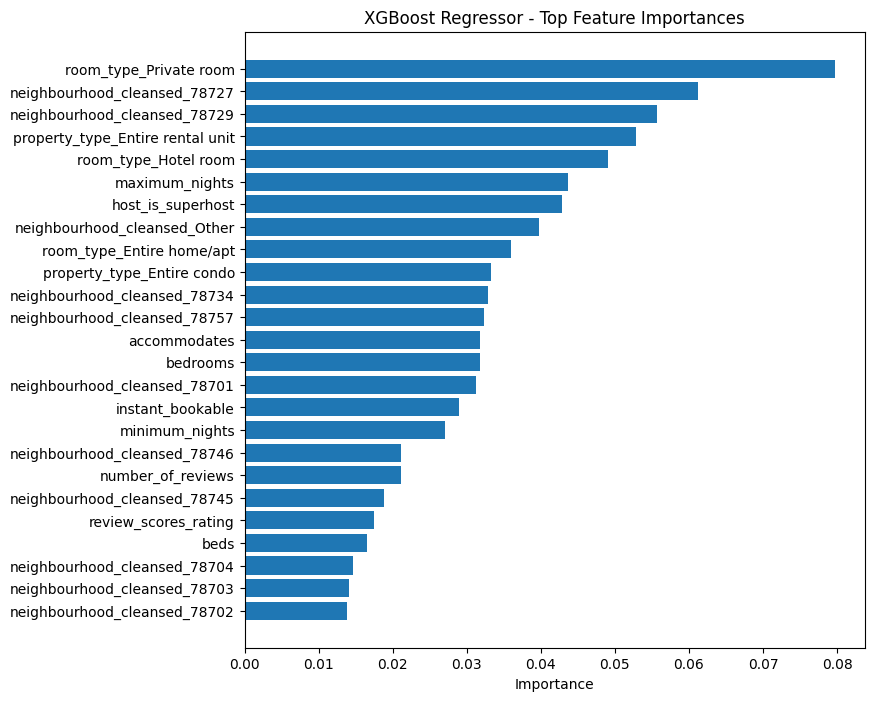

In [49]:
importances = xgb_reg.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(20))

topk = 25
plt.figure(figsize=(8, 8))
plt.barh(imp_df.head(topk)["feature"][::-1], imp_df.head(topk)["importance"][::-1])
plt.title("XGBoost Regressor - Top Feature Importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()


### XGBoost Classification (is_booked)

In [50]:
pos = y_train_book.sum()
neg = len(y_train_book) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb_clf = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
)

xgb_clf.fit(
    X_train, y_train_book,
    eval_set=[(X_valid, y_valid_book)],
    verbose=False
)

proba_test = xgb_clf.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test_book, proba_test)
acc = accuracy_score(y_test_book, pred_test)

print("XGB CLF | Test AUC     :", auc)
print("XGB CLF | Test Accuracy:", acc)


XGB CLF | Test AUC     : 0.7343430546888283
XGB CLF | Test Accuracy: 0.6768133333333334


,feature,importance
2,beds,0.068367
28,property_type_Room in hotel,0.065558
13,instant_bookable,0.050746
12,host_is_superhost,0.039261
15,room_type_Hotel room,0.039126
14,room_type_Entire home/apt,0.025088
16,room_type_Private room,0.025015
1,bedrooms,0.024326
6,maximum_nights,0.022006
23,property_type_Entire rental unit,0.021995


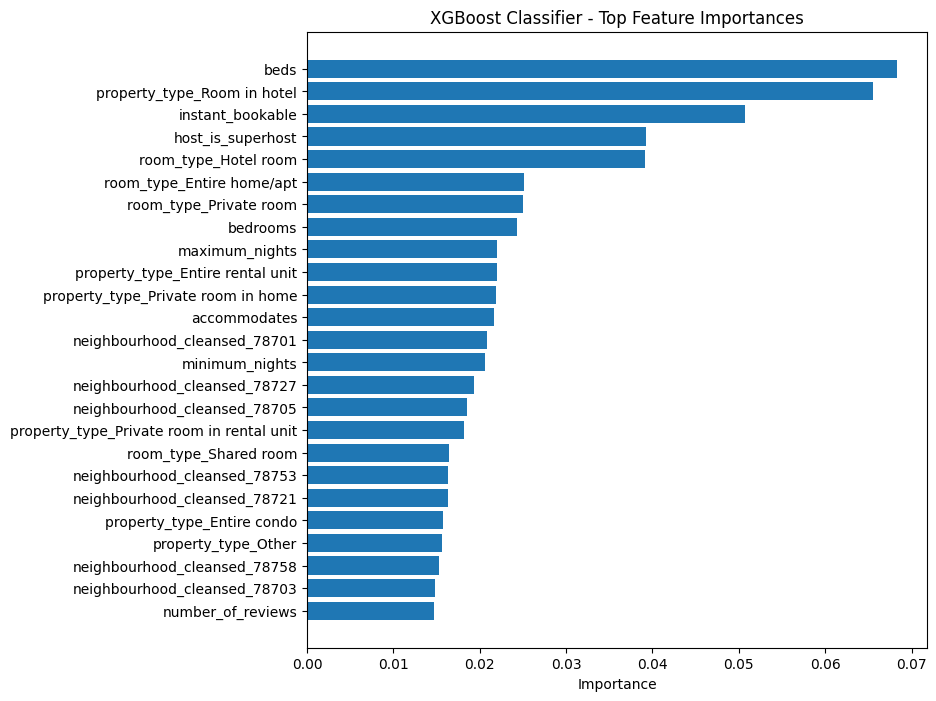

In [51]:
importances = xgb_clf.feature_importances_
imp_df2 = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df2.head(20))

topk = 25
plt.figure(figsize=(8, 8))
plt.barh(imp_df2.head(topk)["feature"][::-1], imp_df2.head(topk)["importance"][::-1])
plt.title("XGBoost Classifier - Top Feature Importances")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()


### Neural networks

In [52]:
def make_nn_reg(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model

def make_nn_clf(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"]
    )
    return model

def timestamp_str():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

INPUT_DIM = X_train.shape[1]

# Separate log dirs (required)
logdir_price = LOGS_DIR / "nn_price" / f"{MODEL_KEY[0]}_{MODEL_KEY[1]}" / timestamp_str()
logdir_book  = LOGS_DIR / "nn_book"  / f"{MODEL_KEY[0]}_{MODEL_KEY[1]}" / timestamp_str()
logdir_price.mkdir(parents=True, exist_ok=True)
logdir_book.mkdir(parents=True, exist_ok=True)

cb_price = [
    keras.callbacks.TensorBoard(log_dir=str(logdir_price)),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
]
cb_book = [
    keras.callbacks.TensorBoard(log_dir=str(logdir_book)),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
]

nn_reg = make_nn_reg(INPUT_DIM)
hist_reg = nn_reg.fit(
    X_train, y_train_price,
    validation_data=(X_valid, y_valid_price),
    epochs=20,
    batch_size=256,
    callbacks=cb_price,
    verbose=1
)

nn_clf = make_nn_clf(INPUT_DIM)
hist_clf = nn_clf.fit(
    X_train, y_train_book,
    validation_data=(X_valid, y_valid_book),
    epochs=20,
    batch_size=256,
    callbacks=cb_book,
    verbose=1
)

print("✅ NN training done.")
print("NN PRICE logdir:", logdir_price)
print("NN BOOK  logdir:", logdir_book)


Epoch 1/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 989593.3125 - mae: 288.3658 - val_loss: 904459.6250 - val_mae: 286.2838
Epoch 2/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 882407.0000 - mae: 265.2763 - val_loss: 877369.0625 - val_mae: 274.8975
Epoch 3/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 852810.6250 - mae: 262.4608 - val_loss: 846930.6250 - val_mae: 269.6395
Epoch 4/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 819771.0625 - mae: 259.5834 - val_loss: 814439.8750 - val_mae: 265.2847
Epoch 5/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 780774.6875 - mae: 255.8410 - val_loss: 782273.8750 - val_mae: 261.6447
Epoch 6/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 746464.8750 - mae: 252.2964 - val_loss: 752085.3750 - val_mae: 257.9437
Epoch 7/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 716429.8125 - mae: 249.5172 - val_loss: 729631.2500 - val_mae: 254.1762
Epoch 8/20
977/977 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 692449.8750 - ma

### Evaluate Neural Net on test

In [54]:
# Regression metrics
pred_nn_price = nn_reg.predict(X_test).ravel()
rmse_nn = mean_squared_error(y_test_price, pred_nn_price) ** 0.5
mae_nn = mean_absolute_error(y_test_price, pred_nn_price)

print("NN REG | Test RMSE:", rmse_nn)
print("NN REG | Test MAE :", mae_nn)

# Classification metrics
proba_nn = nn_clf.predict(X_test).ravel()
pred_nn = (proba_nn >= 0.5).astype(int)

auc_nn = roc_auc_score(y_test_book, proba_nn)
acc_nn = accuracy_score(y_test_book, pred_nn)

print("NN CLF | Test AUC     :", auc_nn)
print("NN CLF | Test Accuracy:", acc_nn)


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step
NN REG | Test RMSE: 751.4053399371186
NN REG | Test MAE : 215.98649229561647
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
NN CLF | Test AUC     : 0.7026681723983288
NN CLF | Test Accuracy: 0.6623466666666666


In [55]:
%load_ext tensorboard
%tensorboard --logdir logs


## Part 4 TensorBoard Screenshots (Required)

### NN Price (Regression) — TensorBoard Scalars Screenshot

<img src="Tensorboard_SS/epoch_loss_R.png" width="1040">
<img src="Tensorboard_SS/epoch_mae_R.png" width="1040">
<img src="Tensorboard_SS/epoch_loss_itr_R.png" width="1040">
<img src="Tensorboard_SS/epoch_mae_itr_R.png" width="1040">


### NN Booking (Classification) — TensorBoard Scalars Screenshot

<img src="Tensorboard_SS/epoch_accuracy_C.png" width="1040">
<img src="Tensorboard_SS/epoch_auc_C.png" width="1040">
<img src="Tensorboard_SS/epoch_acc_itr_C.png" width="1040">
<img src="Tensorboard_SS/epoch_auc_itr_C.png" width="1040">

## Part 4 Discussion

For the price regression NN, both training and validation loss/MAE decrease smoothly and stay fairly close, which suggests stable training and only mild overfitting. The evaluation loss/MAE vs iterations curves also trend down steadily without big spikes, so optimization looks stable (no major divergence or instability). Overall, validation continues improving through the last epoch, so more epochs (with early stopping) could potentially help a bit more.  
For the booking classification NN, training accuracy/AUC increase noticeably faster than validation, and the train–validation gap grows by the final epoch, which indicates overfitting. Validation accuracy/AUC improve only modestly (and start to flatten), meaning generalization is the bottleneck rather than training performance. This pattern is consistent with booking being a noisier/harder target than price (often more imbalance and weaker signal), so it tends to need stronger regularization and careful early stopping based on validation AUC.


In [56]:
results = pd.DataFrame([
    {"model": "XGB_REG", "target": "price", "RMSE": rmse, "MAE": mae, "AUC": np.nan, "ACC": np.nan},
    {"model": "XGB_CLF", "target": "is_booked", "RMSE": np.nan, "MAE": np.nan, "AUC": auc, "ACC": acc},
    {"model": "NN_REG",  "target": "price", "RMSE": rmse_nn, "MAE": mae_nn, "AUC": np.nan, "ACC": np.nan},
    {"model": "NN_CLF",  "target": "is_booked", "RMSE": np.nan, "MAE": np.nan, "AUC": auc_nn, "ACC": acc_nn},
])

print("MODEL_KEY:", MODEL_KEY)
display(results)


MODEL_KEY: ('Austin', '3625')


,model,target,RMSE,MAE,AUC,ACC
0,XGB_REG,price,356.111169,129.906477,NaN,NaN
1,XGB_CLF,is_booked,NaN,NaN,0.734343,0.676813
2,NN_REG,price,751.405340,215.986492,NaN,NaN
3,NN_CLF,is_booked,NaN,NaN,0.702668,0.662347


## Part 2 Interpretation

### Austin | 6 March 2025

Average price is almost flat across the year, with only tiny bumps (slight peak around Oct and a small dip around Mar). Booking probability is clearly seasonal: it’s highest in Jan–Mar, drops hard around Apr–May, then climbs again in the fall and ends stronger in Dec. Weekends vs weekdays show almost no price difference, and weekends have a slightly higher booking probability. By room type, **Hotel room** is the most expensive, then **Entire home/apt**, then **Private room**, and **Shared room** (and these lines are very stable month-to-month).

### Austin | 14 December 2024

Price is very steady with a gentle rise from early months into spring/summer and a noticeable dip in December. Booking probability trends upward through the year, peaking around Oct–Nov and staying relatively high into Dec compared to early months. Weekend vs weekday pricing is nearly identical, with only a tiny weekend lift (if any). Room-type pricing shows the same consistent ranking (Hotel > Entire home/apt > Private > Shared) with minimal seasonality in price.

### Chicago | 11 March 2025

Prices show a small spring peak (around Apr–May) followed by a dip in early summer (Jun–Jul), then stabilize for the rest of the year. Booking probability is highest in late winter/early spring (peaking around Mar), drops to its lowest point around Aug, then recovers in the fall and rises into Dec. Weekend vs weekday average price is nearly the same, while weekends book slightly more often than weekdays. Room types are strongly separated in price (Entire home/apt highest; Private room lowest), and they stay mostly flat across months.

### Chicago | 18 December 2024

Average price jumps up around Mar and remains relatively stable through mid-year, then steps down around Aug–Nov and drops more noticeably in Dec. Booking probability starts low early in the year (lowest around Feb), then steadily rises from late spring onward and peaks around Oct–Dec. Weekday vs weekend prices are almost identical, and weekend booking probability is only slightly higher. Room-type prices are mostly stable, but **December shows a noticeable drop for Hotel room (and a small drop for Private room)** compared to the rest of the year.

### Santa_Cruz | 28 March 2025

Average price is essentially flat, except for a clear dip around March before returning to the normal level. Booking probability is highest in Jan–Mar, falls sharply around Apr–May, then partially rebounds in summer and increases again toward year-end. Weekend vs weekday price is almost unchanged, while weekends book a bit more often. Room-type differences are large and consistent (Hotel highest; Shared lowest), and Private room shows a visible dip around March similar to the overall pattern.

### Santa_Cruz | 31 December 2025

Prices are very stable through most of the year, with a noticeable drop in December. Booking probability is lowest around Feb–Mar, rises slowly through spring, then jumps strongly around July and peaks again in Oct–Dec. Weekday vs weekend price is basically the same, and weekend booking probability is slightly higher. Room-type ranking is stable, but **Private room drops in December**, matching the overall dip.

### WashingtonDC | 13 March 2025

Average price is almost perfectly flat, with a small dip around March. Booking probability peaks around March, then steadily declines to the lowest point in August before recovering into the fall and ending higher in December. Weekend vs weekday prices are essentially identical, while weekend booking probability is a bit higher. Room-type prices are separated, but **Shared room is an extreme outlier (very high)**, which likely comes from a small number of listings or noisy data.

### WashingtonDC | 18 December 2025

Price stays flat throughout the year and drops slightly in December. Booking probability is low in February, then rises steadily through the year and peaks around Oct–Dec. Weekday vs weekend prices are nearly identical and weekend booking probability is slightly higher. Room-type prices are consistent, and again **Shared room looks like a very large outlier**, suggesting potential data quality / small-sample effects.

---

## Part 4 TensorBoard Screenshots (Required)

### NN Price (Regression) — TensorBoard Scalars Screenshot

<p align="center">
  <img src="Tensorboard_SS/epoch_loss_R.png" width="360"/>
  <img src="Tensorboard_SS/epoch_loss_itr_R.png" width="360"/>
</p>
<p align="center">
  <img src="Tensorboard_SS/epoch_mae_R.png" width="360"/>
  <img src="Tensorboard_SS/epoch_mae_itr_R.png" width="360"/>
</p>

### NN Booking (Classification) — TensorBoard Scalars Screenshot

<p align="center">
  <img src="Tensorboard_SS/epoch_accuracy_C.png" width="360"/>
  <img src="Tensorboard_SS/epoch_acc_itr_C.png" width="360"/>
</p>
<p align="center">
  <img src="Tensorboard_SS/epoch_auc_C.png" width="360"/>
  <img src="Tensorboard_SS/epoch_auc_itr_C.png" width="360"/>
</p>

## Part 4 Discussion

The regression TensorBoard curves show training and validation loss/MAE decreasing smoothly, which suggests stable optimization (no exploding/oscillating behavior). Validation stays close to training, so there isn’t severe overfitting, but the validation curve generally sits a bit higher, indicating a small generalization gap. For classification, accuracy and AUC increase over epochs, and validation remains consistently below training, which points to mild overfitting (or simply that the task is harder to generalize). The curves improve early and then start to flatten, suggesting the model is approaching its best performance under the current architecture/hyperparameters. These TensorBoard trends match the final test metrics: the NN performs reasonably, but it does not beat XGBoost (especially on regression). Overall, the booking model shows “clean” learning (AUC rising), while the price model still ends with relatively large error, implying feature interactions/nonlinearities may be better captured by tree boosting here.

---

# Part 5 Final Write-Up (Required)

## Data summary + seasonality (prices + bookings)

Across all cities and snapshots, average prices are surprisingly stable month-to-month, with only small peaks/dips (the clearest being a few “December drops” and occasional March dips). In contrast, booking probability shows much stronger seasonality: several panels start high in Jan–Mar, dip in the middle months, and rebound toward Oct–Dec (though the exact pattern varies by city/snapshot). Weekend vs weekday effects are present but small: prices are almost identical, while weekend booking probability is usually slightly higher. Room type is one of the strongest drivers of price: Hotel room and Entire home/apt are consistently the most expensive, Private rooms are cheaper, and Shared rooms are typically cheapest. WashingtonDC is a special case where Shared room price appears as a large outlier, suggesting a small-sample or noisy category that should be treated carefully.

## Temporal modeling setup (no leakage)

I used a chronological split by month so the model only learns from the past and is evaluated on the future. Concretely, the earlier months are used for training, the next block of months for validation (hyperparameter/early-stopping decisions), and the final months for the test set (final unbiased evaluation). This prevents leakage because no future calendar outcomes (future prices or bookings) are used to fit transformations or model parameters that affect earlier predictions. It also better matches the real deployment setting: predicting upcoming demand/price from historically observed patterns. Any preprocessing (imputation, scaling, one-hot encoding) is fit on the training portion only and then applied to validation/test.

## Model comparison (XGBoost vs Neural Nets)

On price prediction (regression), XGBoost clearly outperforms the neural net: XGB achieves RMSE = 356 and MAE = 129.9, while the NN has RMSE = 751 and MAE = 216 (much worse). On **booking prediction (classification)**, XGBoost also leads, but the gap is smaller: XGB has **AUC = 0.734** and **Accuracy = 0.677**, vs the NN with **AUC = 0.703** and **Accuracy = 0.662**. This suggests the booking target benefits less from complex deep feature learning in this setup, while tree boosting captures strong nonlinear feature interactions effectively. Overall, the results indicate that for this tabular panel data, **XGBoost is the stronger baseline** for both targets.

## TensorBoard insights

The regression loss/MAE curves decrease steadily for both train and validation, showing stable training and gradual improvement, but they plateau at a level consistent with the NN’s relatively high test RMSE/MAE. The classification curves show accuracy/AUC increasing over epochs, with validation consistently below training, which indicates mild overfitting or limited generalization capacity under the chosen architecture. Importantly, the curves are smooth (no instability), so the underperformance is more about model fit/representation than training failure. The TensorBoard patterns align with the final metrics: the NN learns useful signals, but not as effectively as XGBoost on this dataset. If improved, likely levers include stronger regularization, better architecture for tabular data, and/or richer feature engineering.

## Business insights

Predicting **booking probability** is often more directly valuable operationally because it estimates **demand** (and can drive dynamic pricing, minimum-night rules, staffing, and marketing). Price prediction is still useful for hosts as a competitive benchmark (“what price would the market expect for this listing/date?”), but demand is what ultimately determines revenue. Since weekend booking probability is slightly higher but weekend prices barely move, there may be opportunities for hosts/platforms to adjust weekend pricing more aggressively (within reason) in high-demand months. Room type is a major differentiator, so hosts can use these patterns to position their listing (amenities, instant book, superhost status, etc.) to compete within their room-type segment. Finally, the extreme Shared-room prices in WashingtonDC suggest the platform should monitor outliers and consider robust cleaning or minimum-support rules before using such categories for automated pricing decisions.
